In [7]:
import torch
words = open('names.txt', 'r').read().splitlines()

In [8]:
len(words)

32033

In [9]:
min(len(w) for w in words)

2

In [10]:
max(len(w) for w in words)

15

In [5]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

In [6]:
sorted(b.items(), key = lambda kv: -kv[1])

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '<E>'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('<S>', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '<E>'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('<S>', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('<S>', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('<S>', 'l'), 1572),
 (('<S>', 'c'), 1542),
 (('<S>', 'e'), 1531),
 (('j', 'a'), 1473),
 (

In [11]:
import torch

In [20]:
N = torch.zeros((27, 27), dtype=torch.int)

In [21]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [22]:
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        #print(''.join(itos[ix1]), '--->', itos[ix2])
        N[ix1, ix2] += 1

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
#

tensor(33885)


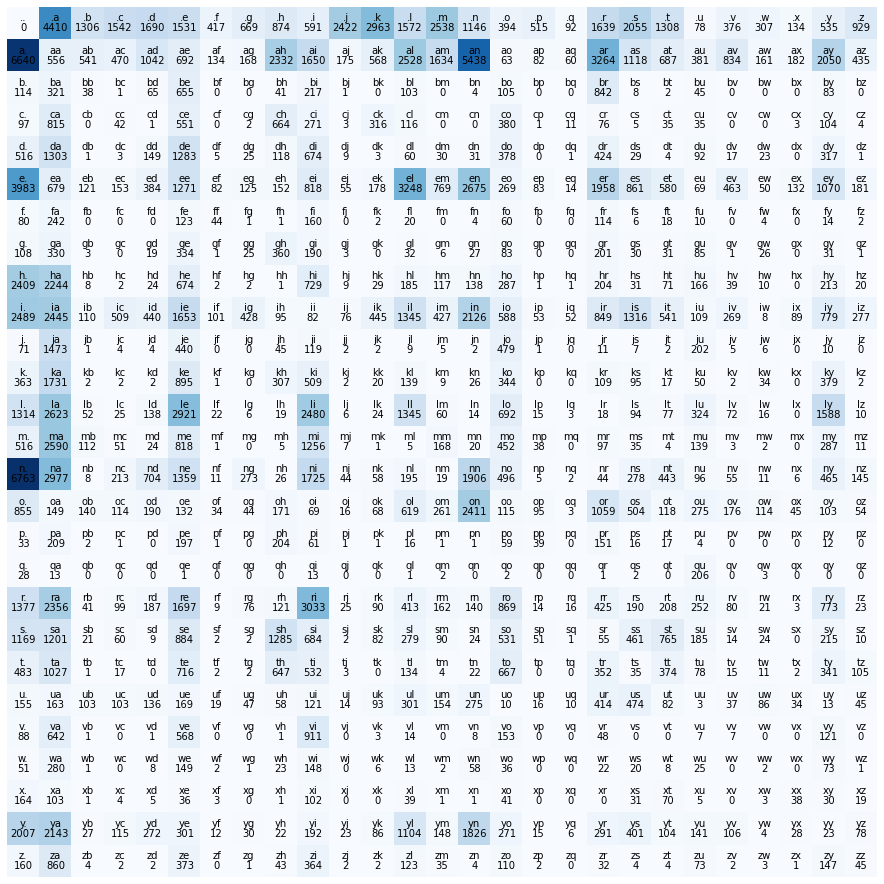

In [24]:
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha = "center", va = "bottom", color='black')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='black')
plt.axis('off');
plt.savefig('bigram_prob.png', dpi=500)
print(N[1].sum())

In [ ]:
print(N[1].sum())

In [26]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

In [27]:
g = torch.Generator().manual_seed(2147483647)

for i in range(20):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print('.' + ''.join(out))

.junide.
.janasah.
.p.
.cony.
.a.
.nn.
.kohin.
.tolian.
.juee.
.ksahnaauranilevias.
.dedainrwieta.
.ssonielylarte.
.faveumerifontume.
.phynslenaruani.
.core.
.yaenon.
.ka.
.jabdinerimikimaynin.
.anaasn.
.ssorionsush.


In [28]:
log_likelihood = 0.0
n = 0
for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
nll = -log_likelihood
print(f'{nll=}')
print(f'Negative log likelihood for bigram model: {nll/n}')

nll=tensor(559951.5625)
Negative log likelihood for bigram model: 2.4543561935424805


In [148]:
import torch.nn.functional as F
# create training set of bigrams (x, y)
xs, ys = [], []

for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [ ]:
# SUMMARY --------------------------->>>>

In [149]:
xs

tensor([ 0,  5, 13, 13,  1])

In [150]:
ys

tensor([ 5, 13, 13,  1,  0])

In [158]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g)

In [159]:
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

In [153]:
probs.shape

torch.Size([5, 27])

In [160]:
nlls = torch.zeros(5)
for i in range(5):
    #i-th bigram:
    x = xs[i].item() # input character index
    y = ys[i].item()
    print('------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x}, {y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', itos[y])
    p = probs[i, y]
    print('probability assigned by the net to the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('======')
print('average negative log likelihood, i.e. loss = ', nlls.mean().item())

------
bigram example 1: .e (indexes 0, 5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0111, 0.0226, 0.0473, 0.0139, 0.0086, 0.0413, 0.0333, 0.0078, 0.0392,
        0.0017, 0.0126, 0.0582, 0.0178, 0.0157, 0.0409, 0.1413, 0.0191, 0.0229,
        0.0704, 0.2134, 0.0123, 0.0008, 0.0058, 0.1115, 0.0037, 0.0147, 0.0120])
label (actual next character): e
probability assigned by the net to the correct character: 0.04132619872689247
log likelihood: -3.186258554458618
negative log likelihood: 3.186258554458618
------
bigram example 2: em (indexes 5, 13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0183, 0.0296, 0.0311, 0.0553, 0.0236, 0.0401, 0.0184, 0.0303, 0.0160,
        0.0133, 0.0393, 0.0081, 0.1678, 0.0214, 0.0285, 0.0040, 0.1159, 0.0166,
        0.0073, 0.0446, 0.0226, 0.1627, 0.0117, 0.0225, 0.0215, 0.0205, 0.0090])
label (actual next character): m
probability assigned by the net to the correct character: 0.02138116396

In [ ]:
# Altogether now!

In [5]:
import torch
words = open('names.txt', 'r').read().splitlines()

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [7]:
# create training set of bigrams (x, y)
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.numel()
print('number of examples: ', num)

number of examples:  228146


In [10]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

In [11]:
import torch.nn.functional as F

losses = []
for k in range(100):
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()

    # backward pass
    W.grad = None
    loss.backward()

    print(loss.item())
    losses.append(loss.item())
    W.data += -50 * W.grad

3.758953332901001
3.371100664138794
3.154043197631836
3.020373582839966
2.927711248397827
2.8604023456573486
2.8097290992736816
2.7701022624969482
2.7380728721618652
2.711496353149414
2.6890029907226562
2.6696884632110596
2.6529300212860107
2.638277292251587
2.6253881454467773
2.613990545272827
2.60386323928833
2.5948216915130615
2.5867116451263428
2.579403877258301
2.572789192199707
2.5667762756347656
2.5612878799438477
2.5562589168548584
2.551633834838867
2.547366142272949
2.543415069580078
2.5397486686706543
2.5363364219665527
2.5331544876098633
2.5301806926727295
2.5273969173431396
2.5247862339019775
2.522334575653076
2.520028829574585
2.517857789993286
2.515810966491699
2.513878345489502
2.512052059173584
2.510324001312256
2.5086867809295654
2.5071346759796143
2.5056614875793457
2.5042612552642822
2.502929210662842
2.5016613006591797
2.5004520416259766
2.4992988109588623
2.498197317123413
2.497144937515259
2.496137857437134
2.495173692703247
2.4942495822906494
2.493363380432129
2.

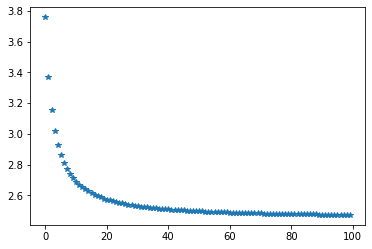

In [13]:
import matplotlib.pyplot as plt
plt.plot(losses, '*')

In [ ]:
first_dist = [0.77, ]
plt.plot()